ASPECTS:
- Video, image utilities
- I/O loading, like json, pickle

VIA:
- Tristan Jia
- zyjia@udel.edu

DEPENDANCE:
- import_ipynb

UTILS LIST:
- load:
    - text
    - pickle
    - csv2dataframe
    - json
    - yaml
- vd(video):
    extract_frames: read frames from video
- 

In [12]:
import os
from os.path import join as pjoin, exists as pexists

import random
from copy import deepcopy as dcopy
from collections import defaultdict as ddict

import pickle
import json
import h5py as h5
import yaml

import pandas as pds
import numpy as np
import cv2

from matplotlib import pyplot as plt

### save:
- text
- json
- pickle
- h5
- dict2cvs
- frames2video (mp4)

In [2]:
def save_text(f_p, d):
    with open(f_p, 'a+') as f:
        f.write(d)
    return False

def save_pickle(f_p, d):
    with open(f_p, 'wb') as f:
        pickle.dump(d, f)

def save_json(f_p, d):
    with open(f_p, 'w+') as f:
        json.dump(d, f)
    return False

def save_h5(f_p, d, d_name):
    with h5.File(f_p, 'a+') as f:
        f.create_dataset(d_name, data=d)
    return False

def save_dict2cvs(f_p, d): # suppose each v of d.values() has the same structure
    lines = []
    for i, (row_id, row_atts) in enumerate(d.items()):
        if i == 0:
            header = ['idx', 'id'] + list(row_atts.keys())
            header = ','.join([str(e) for e in header])
            lines.append(header)
        es = [i, row_id] + list(row_atts.values)
        es = ','.join([str(e) for e in es])
        lines.append(es)
    content = '\n'.join(lines)
    with open(f_p, 'w+') as f:
        f.write(content)
    return False


### load:
- text
- json
- pickle
- h5
- csv2dataframe
- yaml

In [13]:
def load_text(f_p):
    with open(f_p, 'r') as f:
        out = f.read()
    return out

def load_json(f_p):
    with open(f_p, 'r') as f:
        out = json.load(f)
    return out

def load_pickle(f_p):
    with open(f_p, 'rb') as f:
        out = pickle.load(f)
    return out

def load_h5_names(f_p):
    with h5.File(f_p, 'r') as f:
        out = f.keys()
    return out

def load_h5(f_p, d_name):
    with h5.File(f_p, 'r') as f:
        out = f.get(d_name)
    return out

def load_csv2dataframe(f_p):
    out = pds.read_csv(f_p)
    return out

def load_yaml2dict(f_p):
    with open(f_p, 'r') as f:
        out = yaml.safe_load(f)
    return out

### vd(video)
- get
    - atts
    - capatts
    - frames
    - capframes
- concate
    - vs (videos)
    - frames
    - scenes
- text
    - 2v
    - 2frames
- create
    - canvas
- write
    - frames

In [4]:
def vd_getatts(v_p):
    v_cap = cv2.VideoCapture(v_p)
    out = {
        'f_num': int(v_cap.get(cv2.CAP_PROP_FRAME_COUNT)),
        'f_w': int(v_cap.get(cv2.CAP_PROP_FRAME_WIDTH)),
        'f_h': int(v_cap.get(cv2.CAP_PROP_FRAME_HEIGHT)),
        'fps': int(v_cap.get(cv2.CAP_PROP_FPS)),
    }
    return out
def vd_getcapatts(v_cap):
    out = {
        'f_num': int(v_cap.get(cv2.CAP_PROP_FRAME_COUNT)),
        'f_w': int(v_cap.get(cv2.CAP_PROP_FRAME_WIDTH)),
        'f_h': int(v_cap.get(cv2.CAP_PROP_FRAME_HEIGHT)),
        'fps': int(v_cap.get(cv2.CAP_PROP_FPS)),
    }
    return out
    
def vd_getframes(v_p):
    v_cap = cv2.VideoCapture(v_p)
    out = vd_getcapframes(v_cap)
    return out
def vd_getcapframes(v_cap):
    success = True
    frames = []
    while success:
        success, frame = v_cap.read()
        frames.append(frame)
    frames = frames[:-1]
    return np.stack(frames, axis=0)

def vd_concatevs(v_ps, direction): 
    assert(direction in ['h', 'v', 'a'])    # 'h' (horizontal), 'v'(vertical), 'a' (append)
    vs_frames = []
    for v_p in v_ps:
        frames = vd_getframes(v_p)
        vs_frames.append(frames)
    frames_new = vd_concateframes(vs_frames, direction)
    return frames_new
def vd_concateframes(vs_frames, direction):
    assert(direction in ['h', 'v', 'a'])    # 'h' (horizontal), 'v'(vertical), 'a' (append)
    frames_new = []
    if direction == 'h':
        for i in range(vs_frames[0].shape[0]):
            frame = [v_frames[i] for v_frames in vs_frames]
            frame = np.concatenate(frame, axis=1)
            frames_new.append(frame)
    elif direction == 'v':
        for i in range(vs_frames[0].shape[0]):
            frame = [v_frames[i] for v_frames in vs_frames]
            frame = np.concatenate(frame, axis=0)
            frames_new.append(frame)
    elif direction == 'a':
        frames_new = np.stack(vs_frames, axis=0)
    return np.array(frames_new).astype(np.uint8)
def vd_concatescenes(scenes_frames):    # display each scene/clip from left to right
    frames_full = []
    for i, scene_i in enumerate(scenes_frames):
        frames_sub_pre = []
        frames_sub_post = []
        for j, scene_j in enumerate(scenes_frames):
            if j < i:
                frames_sub_pre.append(scene_j[-1])
            elif j > i:
                frames_sub_post.append(scene_j[0])
        for frame in scene_i:
            frame_full = np.concatenate(frames_sub_pre + [frame] + frames_sub_post, axis=1)
            frames_full.append(frame_full)
    return np.array(frames_full).astype(np.uint8)

def vd_text2v(v_p, lines, loc):
    frames = vd_getframes(v_p)
    return vd_text2frames(frames, lines, loc)
def vd_text2frames(frames, lines, loc):
    frames_new = []
    for frame in frames:
        frames_new.append(img_text2imgnpa(frame, lines, loc))
    return frames_new

def vd_createcanvas(f_n, f_w, f_h, f_c=3, color256=(0,0,0)):
    if f_c == 1:
        frames_new = np.full((f_n, f_h, f_w), color256)
    else:
        frames = []
        for i in range(3):
            frames_c = np.full((f_n, f_h, f_w), color256[i])
            frames.append(frames_c)
        frames_new = np.stack(frames, axis=-1)
    return frames_new

def vd_writeframes(f_p, fps, frames): # frames is a list/array of np array
    out = cv2.VideoWriter(f_p, cv2.VideoWriter_fourcc(*'mp4v'), fps, (frames[0].shape[1], frames[0].shape[0]))
    for frame in frames:
        out.write(frame)
    out.release()

def vd_sample(v_p, n=5):
    frames = vd_getframes(v_p)
    idxs_sampled = random.sample(range(len(frames)), n)
    idxs_sampled.sort()
    fs_sampled = np.array([frames[i] for i in idxs_sampled])
    return img_concateimgnpa(fs_sampled, 'h')

def vd_cropv(v_p, t=0, r=0, b=0, l=0):
    frames = vd_getframes
    return vd_cropframes(frames, t, r, b, l)
def vd_cropframes(frames, t=0, r=0, b=0, l=0):
    f_n, f_h, f_w, f_c = frames.shape
    assert t>=0 and t<f_h
    assert r>=0 and r<f_w
    assert b>=0 and b<f_h
    assert l>=0 and l<f_w
    return frames[:, t:(f_h-b), l:(f_w-r)]


### img
- text
    - 2img
    - 2imgnpa
- create
    - canvas
- concate
    - img
    - imgnpa
- show
    - cv2

In [5]:
def img_text2img(img_p, lines, loc, fontColor=(255,255,255)):
    img_npa = cv2.imread(img_p)
    return img_text2imgnpa(img_npa, lines, loc, fontColor)
def img_text2imgnpa(img_npa, lines, loc, fontColor=(255,255,255)):
    font                   = cv2.FONT_HERSHEY_SIMPLEX
    bottomLeftCornerStart  = list(dcopy(loc))
    fontScale              = 0.5
    thickness              = 1
    lineType               = 2
    bottomLeftCornerOfText = bottomLeftCornerStart
    for line in lines:
        cv2.putText(img_npa, line, 
            bottomLeftCornerOfText, 
            font,
            fontScale,
            fontColor,
            thickness,
            lineType)
        bottomLeftCornerOfText[1] += 30
    return img_npa

def img_createcanvas(w, h, c=3, color256=(0, 0, 0)):
    if c == 1:
        canvas_new = np.full((h, w), color256)
    else: 
        canvas_cs = []
        for i in range(3):
            canvas = np.full((h, w), color256[i])
            canvas_cs.append(canvas)
        canvas_new = np.stack(canvas_cs, axis=-1)
    return canvas_new.astype(np.uint8)


def img_concateimg(img_ps, direction, separator_width=0):
    assert(direction in ['h', 'v'])    # 'h' (horizontal), 'v'(vertical)
    imgs = []
    for img_p in img_ps:
        imgs.append(cv2.imread(img_p))
    return img_concateimgnpa(imgs, direction, separator_width)
def img_concateimgnpa(img_npas, direction, separator_width=0):
    assert(direction in ['h', 'v'])    # 'h' (horizontal), 'v'(vertical)
    if direction == 'h':
        sep_line = np.full((img_npas[0].shape[0], separator_width, 3), 255)
        img_npas_new = []
        for i, img_npa in enumerate(img_npas):
            img_npas_new.append(img_npa)
            if i < len(img_npas)-1:
                img_npas_new.append(sep_line)
        img_new = np.concatenate(img_npas_new, axis=1)
    elif direction == 'v':
        sep_line = np.full((separator_width, img_npas[0].shape[1], 3), 255)
        img_npas_new = []
        for i, img_npa in enumerate(img_npas):
            img_npas_new.append(img_npa)
            if i < len(img_npas)-1:
                img_npas_new.append(sep_line)
        img_new = np.concatenate(img_npas_new, axis=0)
    return img_new.astype(np.uint8)
    
def img_cv22rgb(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)



### Let's demo tutils!

In [6]:
v_shape = vd_getatts('demo.mp4')
frames = vd_getframes('demo.mp4')
print(v_shape)

{'f_num': 18, 'f_w': 454, 'f_h': 256, 'fps': 30}


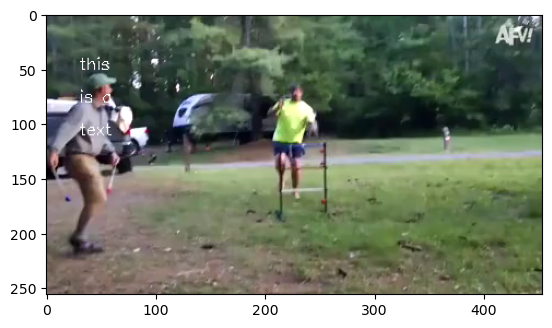

In [7]:
img = frames[0]
img = img_cv22rgb(img)
img = img_text2imgnpa(img, ['this', 'is a', 'text'], loc=[30, 50])

plt.imshow(img)

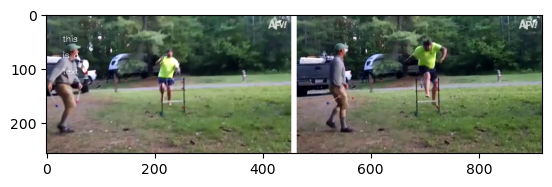

In [8]:
img2 = img_cv22rgb(frames[17])
img = img_concateimgnpa([img, img2], direction='h', separator_width=10)

plt.imshow(img)

(356, 918, 3)


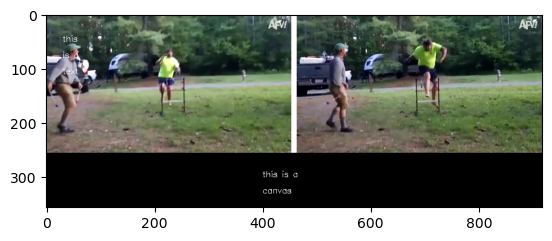

In [9]:
img3 = img_createcanvas(w=img.shape[1], h=100)
img = img_concateimgnpa([img, img3], direction='v')


print(img.shape)
img = img_text2imgnpa(img, ['this is a ', 'canvas'], loc=[400, 300])

plt.imshow(img)

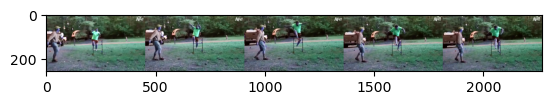

In [10]:
v_sample_img = vd_sample("demo.mp4")
plt.imshow(v_sample_img)

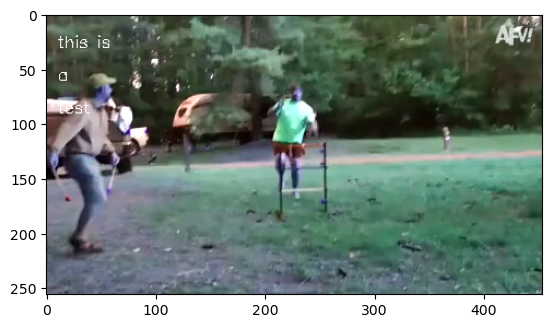

In [11]:
frames = vd_text2frames(frames, ['this is ', 'a', 'test'], [10, 30])
plt.imshow(frames[0])
plt.show()